In [17]:
%matplotlib inline
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from opto_untils import session_dirs
from plot_untils import shiftedColorMap, template_reorder, interpolate_waveform
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps


colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

In [2]:
tag_info = pd.read_csv('/root/capsule/code/data_management/cortex_tagged_units.csv')
session_ids = tag_info['session_id'].unique()

In [26]:
y_neighbors_to_keep = 2
samples_to_keep = [-20, 40]
selection = 'all' # 'all' or 'major'

all_wf = []
all_session = []
all_units = []
all_amps = []

for session_ind, session_id in enumerate(session_ids):
    unit_list = [int(x) for x in tag_info['unit_ids'][session_ind].split(', ')]

    # load waveforms info
    session_dir = session_dirs(session_id)
    we = si.load_waveforms(session_dir['postprocessed_dir'], with_recording=False)
    unit_ids = we.sorting.get_unit_ids()
    all_templates = we.get_all_templates()
    all_channels = we.sparsity.channel_ids
    all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
    unit_spartsiity = we.sparsity.unit_id_to_channel_ids
    channel_locations = we.get_channel_locations()
    unit_locations = we.load_extension("unit_locations").get_data(outputs="by_unit")
    right_left = channel_locations[:, 0]<20

    for unit_id in unit_list:
        unit_ind = np.where(unit_ids == unit_id)[0][0]
        curr_template = all_templates[unit_ind]
        reordered_template = template_reorder(curr_template, right_left, all_channels_int, sample_to_keep = samples_to_keep, y_neighbors_to_keep = 5, orginal_loc = False)
        reordered_template = interpolate_waveform(reordered_template)
        all_amps.append(np.nanmin(reordered_template))
        
        reordered_template = reordered_template[5-y_neighbors_to_keep:y_neighbors_to_keep-5, :]
        reordered_template = reordered_template/np.nanmin(reordered_template)  # Normalize the waveform
        all_wf.append(reordered_template)
        all_session.append(session_id)
        all_units.append(unit_id)

tagged_df = pd.DataFrame({'session_id': all_session, 'unit_id': all_units, 'waveform': all_wf, 'amplitude': all_amps})
tagged_df.to_pickle(os.path.join('/root/capsule/scratch/all_wf/amp_100', 'tagged_wf.pkl'))

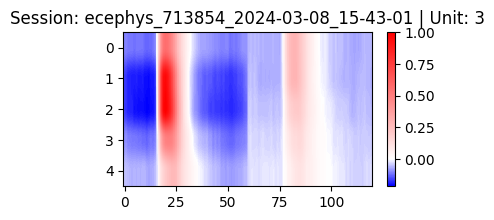

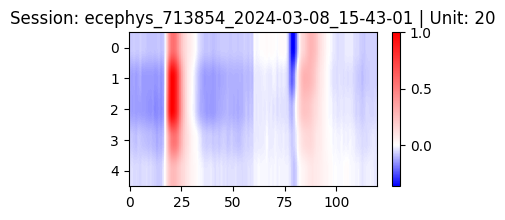

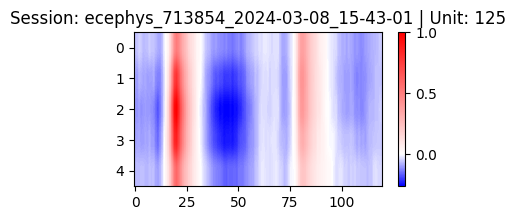

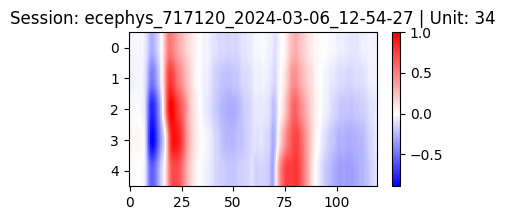

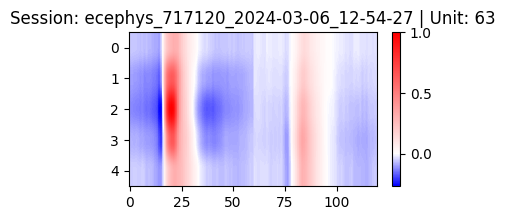

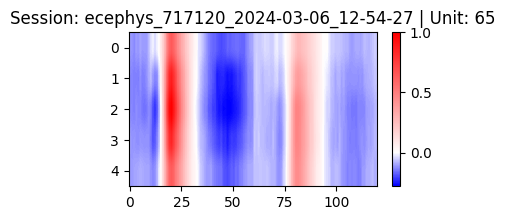

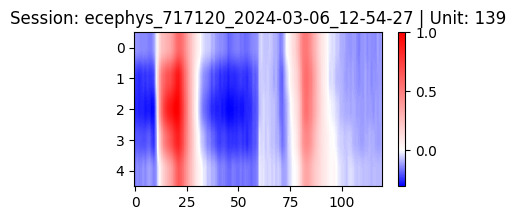

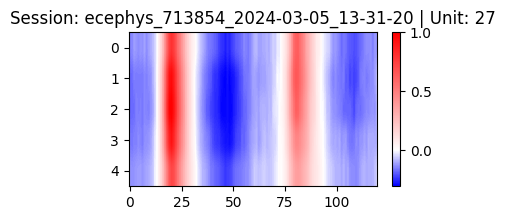

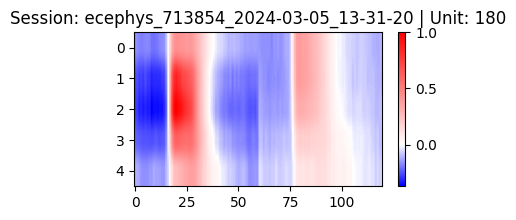

In [24]:
for unit_ind in range(len(tagged_df)):
    plt.figure(figsize=(4, 2))
    shifted_cmap = shiftedColorMap(b_w_r_cmap, min_val=np.nanmin(tagged_df['waveform'][unit_ind]), max_val=1, name='shifted')
    plt.imshow(tagged_df['waveform'][unit_ind], aspect='auto', cmap=shifted_cmap)
    plt.title(f"Session: {tagged_df['session_id'][unit_ind]} | Unit: {tagged_df['unit_id'][unit_ind]}")
    plt.colorbar()
    plt.show()